## <font color='Blue'>Introduction</font>
###  In this exercise, we run simulation in a 2D single layer two-phase model.

## <font color='blue'>The objectives:</font>
1. Introduce custom <font color='red'>'Model'</font> class based on 
 * Class [DartsModel](./darts/models/darts_model.py) with base model capabilities
 * Class [StructReservoir](./darts/models/reservoirs/struct_reservoir.py) with structured reservoir
 * Class [Deadoil](./darts/models/physics/dead_oil_python.py) for basic dead oil physics
 * Class [Deadoil-properties](./darts/models/physics/do_properties_python.py) for dead oil properties, such as density, viscosity and relative permeability
2. Use run_python procedure to control run from the python script
3. Introduce wells and time-dependent well controls
4. Redefine physical properties and run simulation with custom-defined property.

## <font color='Blue'>Let's start!</font>


<img style="float: left;" src="slides/Slide1.JPG" width="60%">

In [1]:
from darts.models.reservoirs.struct_reservoir import StructReservoir
from darts.models.physics.dead_oil_python import DeadOil
from darts.models.darts_model import DartsModel
from darts.engines import value_vector
from darts.tools.keyword_file_tools import load_single_keyword

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

<img style="float: left;" src="slides/Slide2.JPG" width="60%">

#### Brief Introduction of model inheritance
* Here create the <font color='red'>'Model' </font>  class, which inherits from <font color='red'>DartsModel</font> (the base class).
* It keeps all the functionalities of <font color='red'>DartsModel</font> and can also be extended to add more functionalities.
* If a function is redefined in subclass, the function in base class with identical name will be overridden.

In [2]:
class Model(DartsModel):
    def __init__(self, perm=None):
        # call base class constructor
        super().__init__()

        # measure time spend on reading/initialization
        self.timer.node["initialization"].start()

        # create reservoir
        self.nx = 60
        self.ny = 60
        self.nz = 1
        
        self.dx = 8
        self.dy = 8
        self.dz = 4

        if (perm is None):
            perm = np.ones(self.nx*self.ny)*3000
        else:
            perm = perm.reshape(self.nx*self.ny)
            
        self.permx = perm
        self.permy = perm
        self.permz = 0.1 * perm
        self.poro = 0.2
        self.depth = 4000

        # run discretization
        self.reservoir = StructReservoir(self.timer, nx=self.nx, ny=self.ny, nz=self.nz, dx=self.dx, dy=self.dy,
                                         dz=self.dz, permx=self.permx, permy=self.permy, permz=self.permz,
                                         poro=self.poro, depth=self.depth)


        self.reservoir.add_well("INJ1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], 1, 1, 1,  well_index=10)

        self.reservoir.add_well("PRD1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.nx, self.ny, 1, well_index=10)

        # create physics
        self.physics = DeadOil(timer=self.timer, physics_filename='physics.in',
                               n_points=401, min_p=300, max_p=600, min_z=1e-8)

        self.params.first_ts = 1
        self.params.mult_ts = 2
        self.params.max_ts = 50
        self.params.tolerance_newton = 1e-1
        self.params.tolerance_linear = 1e-3

        self.inj = [1] # self.inj = [0] for oil injection

        self.runtime = 1000

        self.timer.node["initialization"].stop()

    def set_initial_conditions(self):
        self.physics.set_uniform_initial_conditions(self.reservoir.mesh, uniform_pressure=400,
                                                    uniform_composition=[0.1])

    def set_boundary_conditions(self):
        for i, w in enumerate(self.reservoir.wells):
            if w.name[:3] == "INJ":
                w.control = self.physics.new_bhp_water_inj(410, self.inj)
                # w.constraint = self.physics.new_rate_water_prod(210)
            else:
                w.control = self.physics.new_bhp_prod(390)

<img style="float: left;" src="slides/Slide3.JPG" width="60%">

In [3]:
m = Model()
m.init()
m.run_python()
m.print_timers()

darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...
# 1 	T =   1	DT =  1	NI = 1	LI=5
# 2 	T =   3	DT =  2	NI = 1	LI=4
# 3 	T =   7	DT =  4	NI = 2	LI=8
# 4 	T =  15	DT =  8	NI = 3	LI=13
# 5 	T =  31	DT = 16	NI = 4	LI=18
# 6 	T =  63	DT = 32	NI = 6	LI=27
# 7 	T = 113	DT = 50	NI = 8	LI=35
# 8 	T = 163	DT = 50	NI = 6	LI=27
# 9 	T = 213	DT = 50	NI = 6	LI=27
# 10 	T = 263	DT = 50	NI = 5	LI=24
# 11 	T = 313	DT = 50	NI = 5	LI=23
# 12 	T = 363	DT = 50	NI = 5	LI=22
# 13 	T = 413	DT = 50	NI = 5	LI=22
# 14 	T = 463	DT = 50	NI = 4	LI=19
# 15 	T = 513	DT = 50	NI = 4	LI=19
# 16 	T = 563	DT = 50	NI = 4	LI=21
# 17 	T = 613	DT = 50	NI = 4	LI=21
# 18 	T = 663	DT = 50	NI = 4	LI=21
# 19 	T = 713	DT = 50	NI = 4	LI=20
# 20 	T = 763	DT = 50	NI = 4	LI=20
# 21 	T = 813	DT = 50	NI = 4	LI=20
# 22 	T = 863	DT = 50	NI = 4	LI=20
# 23 	T = 913	DT = 50	NI = 5	LI=25
# 24 	T = 963	DT = 50	NI = 5	LI=26
# 25 	T = 1000	DT = 37	NI = 4	LI=20
TS

In [4]:
%matplotlib inline
import pandas as pd
time_data = pd.DataFrame.from_dict(m.physics.engine.time_data)
# wirte timedata to output file
time_data.to_pickle("darts_time_data.pkl")
# write timedata to excel file
writer = pd.ExcelWriter('time_data.xlsx')
time_data.to_excel(writer, 'Sheet1')
writer.save()

<img style="float: left;" src="slides/Slide4.JPG" width="60%">

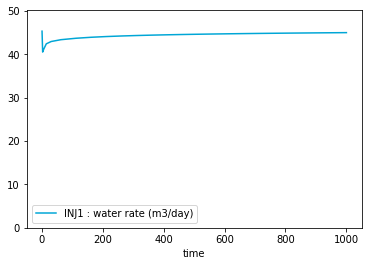

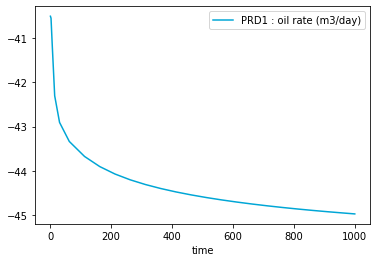

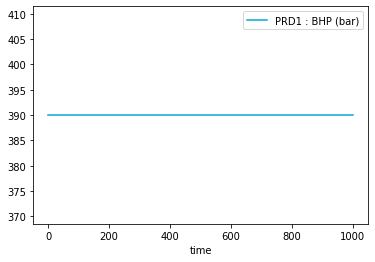

In [6]:
# read data from output file
td = pd.read_pickle("darts_time_data.pkl")
# plot production rates
from darts.tools.plot_darts import *
plot_water_rate_darts('INJ1', td)
plot_oil_rate_darts('PRD1', td)
plot_bhp_darts('PRD1', td)
plt.show()

<img style="float: left;" src="slides/Slide5.JPG" width="60%">

In [7]:
# process active grid
X = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p = X[0 : 2*nb : 2]
z = X[1 : 2*nb : 2]

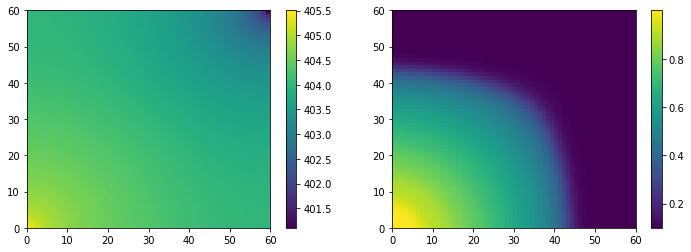

In [9]:
# plot solution
plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
plt.pcolor(p.reshape(m.ny, m.nx))
plt.colorbar()

plt.subplot(122)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.colorbar()

<img style="float: left;" src="slides/Slide6.JPG" width="60%">

In [16]:
perm = load_single_keyword('data.in', 'PERMX')
n = Model(perm)
n.init()
n.run(4000) # 2000 days
print('Simulation completed')

# process active grid
X = np.array(n.physics.engine.X, copy=False)
nb = n.nx * n.ny

p = X[0 : 2*nb : 2]
z = X[1 : 2*nb : 2]                           

Reading PERMX from /home/jovyan/data.in... 3600 values have been read.
darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...
Simulation completed


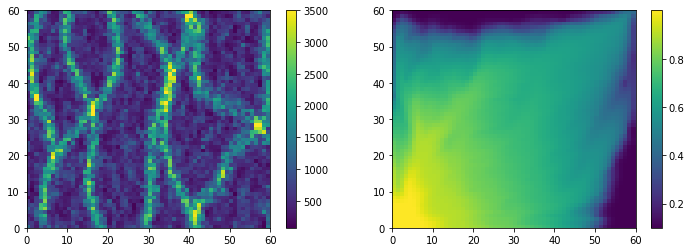

In [17]:
# plot solution
plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
plt.pcolor(perm.reshape(n.ny, n.nx))
plt.colorbar()

plt.subplot(122)
plt.pcolor(z.reshape(n.ny, n.nx))
plt.colorbar()
plt.show()